# Initial filters and ICA for first array

In [1]:
import pickle
import numpy as np
import pandas as pd
import mne
import wfdb
import os
from matplotlib import pyplot as plt

In [2]:
X_S = pickle.load(open('X_S.pickle', 'rb'))
X_S_file = pickle.load(open('X_S_file.pickle', 'rb'))
X_NS = pickle.load(open('X_S.pickle', 'rb'))
X_NS_file = pickle.load(open('X_NS_file.pickle', 'rb'))
chan_order_dict = pickle.load(open('chan_order_dict.pickle', 'rb'))

Creating RawArray with float64 data, n_channels=22, n_times=76800


<ipython-input-3-dbb57630da35>:3: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['T7-P7', 'P7-O1', 'FP1-F3', 'FP2-F8', 'T8-P8', 'P8-O2', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8']. Their position has been left untouched.
  sfreq=256,ch_types='eeg',montage='standard_postfixed')


    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.


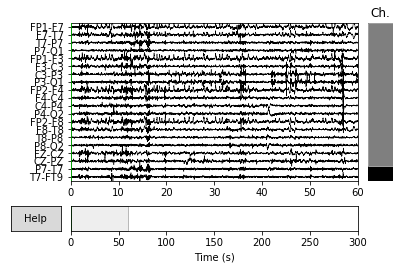

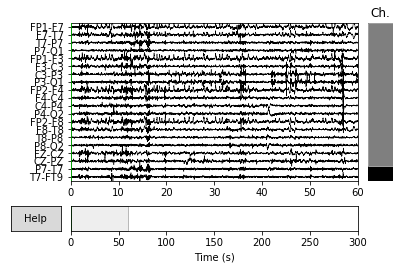

In [3]:
# Take a look at first example, first 60 seconds
xs_info = mne.create_info(ch_names=[i for i in chan_order_dict.keys()],
                          sfreq=256,ch_types='eeg',montage='standard_postfixed')
xs_mne = mne.io.RawArray(X_S[0],xs_info)
xs_mne.plot(duration=60,scalings='auto')

In [4]:
# Average reference
xs_mne.set_eeg_reference()

Applying average reference.
Applying a custom EEG reference.


<RawArray  |  None, n_channels x n_times : 22 x 76800 (300.0 sec), ~12.9 MB, data loaded>

In [5]:
# High pass filter 1Hz
xs_mne.filter(.05, None, n_jobs=1, fir_design='firwin')

Setting up high-pass filter at 0.05 Hz
l_trans_bandwidth chosen to be 0.1 Hz
Filter length of 16897 samples (66.004 sec) selected


<RawArray  |  None, n_channels x n_times : 22 x 76800 (300.0 sec), ~12.9 MB, data loaded>

In [6]:
# ICA, get componenets
ica = mne.preprocessing.ICA(random_state=1234)
ica.fit(xs_mne)
print(ica)

Fitting ICA to data using 22 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 22
Fitting ICA took 0.9s.
<ICA  |  raw data decomposition, fit (fastica): 76800 samples, 22 components, channels used: "eeg">


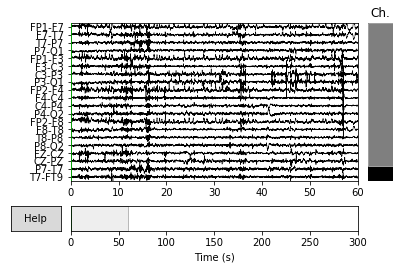

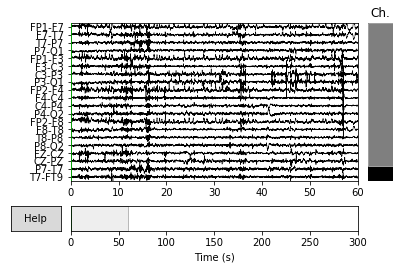

In [7]:
xs_mne.plot(duration=60,scalings='auto')

<ipython-input-8-b619e396fa88>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'P7', 'FP1', 'T7', 'FP2'}. Applying running numbers for duplicates.
  ica.plot_components()


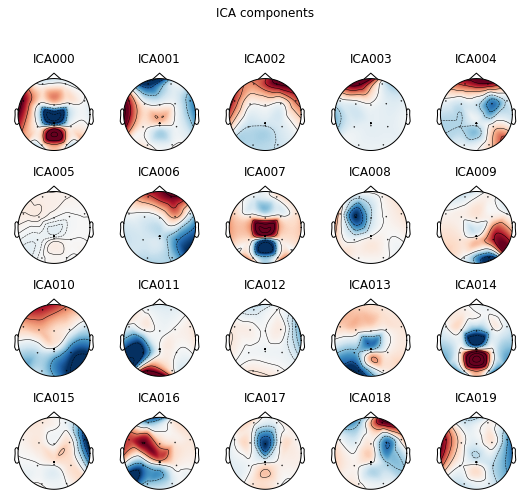

<ipython-input-8-b619e396fa88>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'P7', 'FP1', 'T7', 'FP2'}. Applying running numbers for duplicates.
  ica.plot_components()


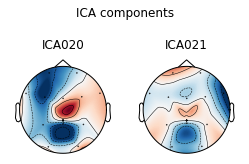

[<Figure size 540x504 with 20 Axes>, <Figure size 259.2x180 with 2 Axes>]

In [8]:
# Plot components (montage=standard_postfixed, inferred from data?)
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-9-9764bd46301c>:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'P7', 'FP1', 'T7', 'FP2'}. Applying running numbers for duplicates.
  ica.plot_properties(xs_mne, picks=[2,3])
<ipython-input-9-9764bd46301c>:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'P7', 'FP1', 'T7', 'FP2'}. Applying running numbers for duplicates.
  ica.plot_properties(xs_mne, picks=[2,3])


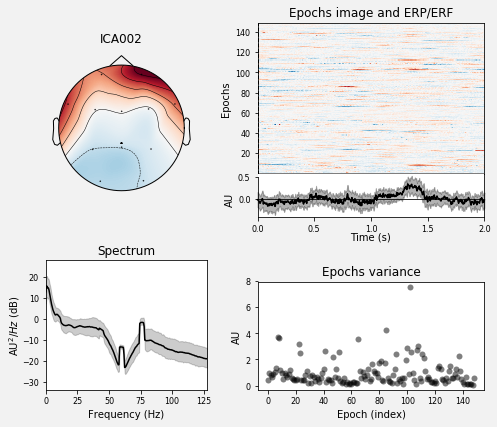

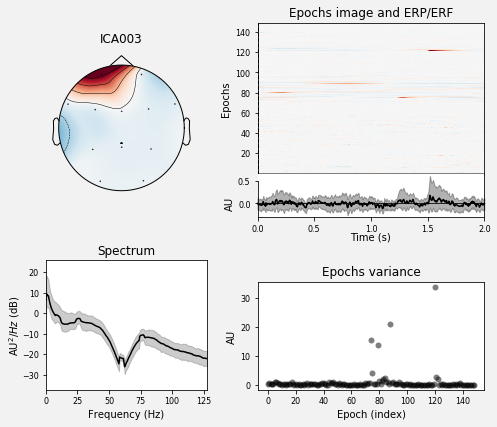

[<Figure size 504x432 with 5 Axes>, <Figure size 504x432 with 5 Axes>]

In [9]:
ica.plot_properties(xs_mne, picks=[2,3])

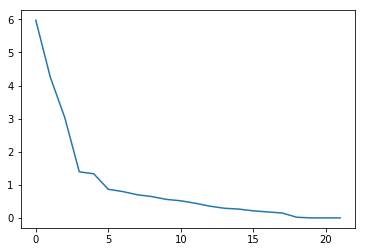

In [10]:
plt.plot(ica.pca_explained_variance_)

Ideally, I'd have the ability easily designate eog or ecg, but with this dataset I don't. I'll take a look at what excluding components 2 and 3 would look like below.

In [11]:
# Exclude 2 and 3
ica.exclude.extend([2,3])

Transforming to ICA space (22 components)
Zeroing out 2 ICA components


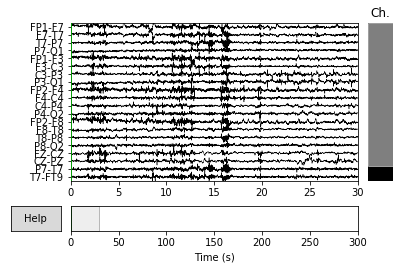

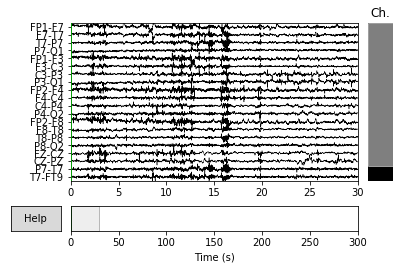

In [12]:
xs_mne_c = xs_mne.copy()
ica.apply(xs_mne_c)
xs_mne_c.plot(duration=30,scalings='auto')

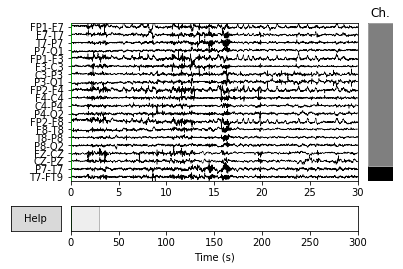

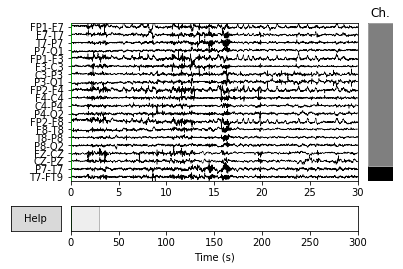

In [13]:
xs_mne.plot(duration=30,scalings='auto')

There is a lot more I could do to pre-process these signals, though I'd probably have to get creative to do it without dedicated eog signales. 